# Requirements
If you are running this tutorial on collab we strongly suggest switching to a GPU environment - especially for the deep learning stage.

If you are running it locally and have no access to a dedicated and/or compatible GPU, or are out of resources on collab, worry not! Simply run the experiments for less epochs so that you can follow along!


In [1]:
import os

import librosa
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import scipy.io as sio
import scipy.signal
import random
import re

from scipy.io import wavfile

from PIL import Image
from tqdm import tqdm


# Part 1. Signal Processing

You have access to processed samples from the [2022 CirCor DigiScope dataset](https://physionet.org/content/circor-heart-sound/1.0.3/) available on the [HuggingFace Dataset Hub](https://huggingface.co/docs/hub/datasets-overview).

Please click [this link](https://huggingface.co/datasets/miguellmartins/circor-digiscope-physionet22-processed) and inspect the attributes of the original (raw) dataset. This HF Dataset has two splits: "original" and "processed".

The "processed" version contains the resulting sounds after filtering and denoising (using the techniques we will discuss in this section).

These data may be interfaced using the [HuggingFace API](https://huggingface.co/docs/). The actual files are stored locally and remotely using [Apache Parquet](https://parquet.apache.org/).


In [2]:
from datasets import load_dataset, Audio, DatasetDict

/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
circor = load_dataset('miguellmartins/circor-digiscope-physionet22-processed')

Inspect the attributes of the datasets. Store splits in sepearate objects

In [4]:
print(circor)
original = circor['original']
processed = circor['processed']

DatasetDict({
    original: Dataset({
        features: ['filename', 'recording', 'recording_label', 'heart_state_labels'],
        num_rows: 3363
    })
    processed: Dataset({
        features: ['filename', 'recording', 'recording_label', 'heart_state_labels'],
        num_rows: 3363
    })
})


In [5]:
# You can check the name of the original wav file, the waveform,
# and the sampling rate of each recording

## 1.1 Pick a random sound and use the below function to visualize the sound and its annotation

Remember that each heart state is codified with categorical labels. So
* 1: S1
* 2: Systole
* 3: S2
* 4: Diastole


In [6]:
def plot_sound_and_label(x, y, sampling_rate=4000):
    assert len(x) == len(y)
    number_of_samples = len(x)
    # Time (duration) = T_i / sample_rate
    time = np.arange(number_of_samples) / sampling_rate

    # Plotting x and y together
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot x on the primary y-axis
    ax1.plot(time, x, label='x (PCG)', color='b')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude of o', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a secondary y-axis for y
    ax2 = ax1.twinx()
    ax2.step(time, y, label='y (Heart Sattes)', color='r', where='post', linewidth=2)
    ax2.set_ylabel('y (Labels)', color='r')
    ax2.set_yticks([1, 2, 3, 4])
    ax2.tick_params(axis='y', labelcolor='r')

    fig.suptitle('PCG Amplitude and Heart Sound Labels')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

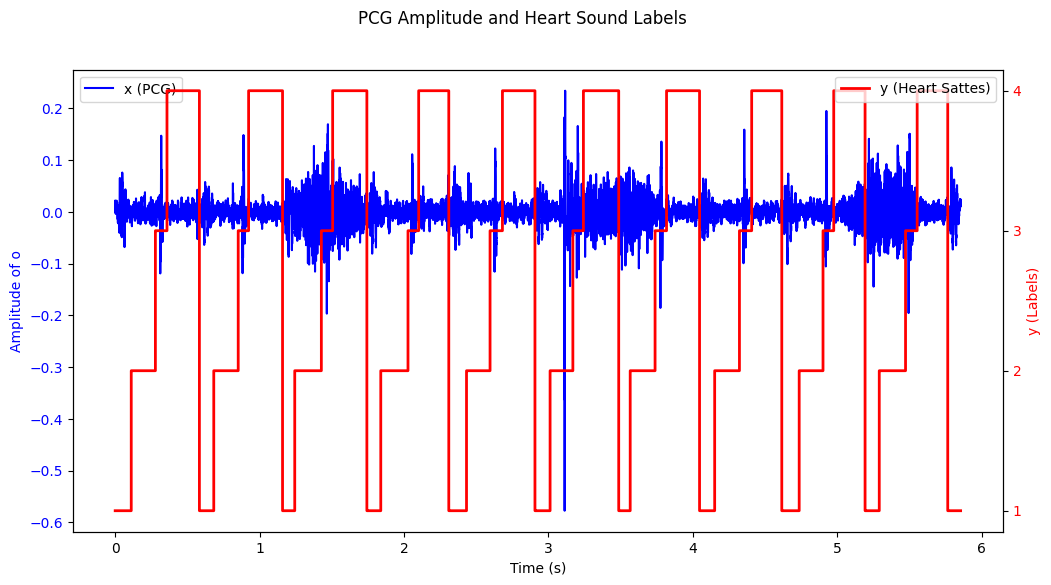

In [7]:
sample_idx = 1  # chose an idx i and visualize it


plot_sound_and_label(x=original[sample_idx]['recording']['array'],
                     y=original[sample_idx]['heart_state_labels'],
                     sampling_rate=original[sample_idx]['recording']['sampling_rate'])

# 2.1.1 Band-pass filtering
The information about the heart typically is assumed to be in [the [25-400] Hz band](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10242001).

We are specifically using [Butterworth filters](https://en.wikipedia.org/wiki/Butterworth_filter) for this purpose.

Run the cells below to visualize these filters.

Apply the band-pass filters to a sound of your choice from the dataset.

/var/folders/hn/v81yb_vd3899ls9424rlwq380000gn/T/ipykernel_14881/923919802.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_hp, 20 * np.log10(np.abs(h_hp)), label='Highpass Filter')


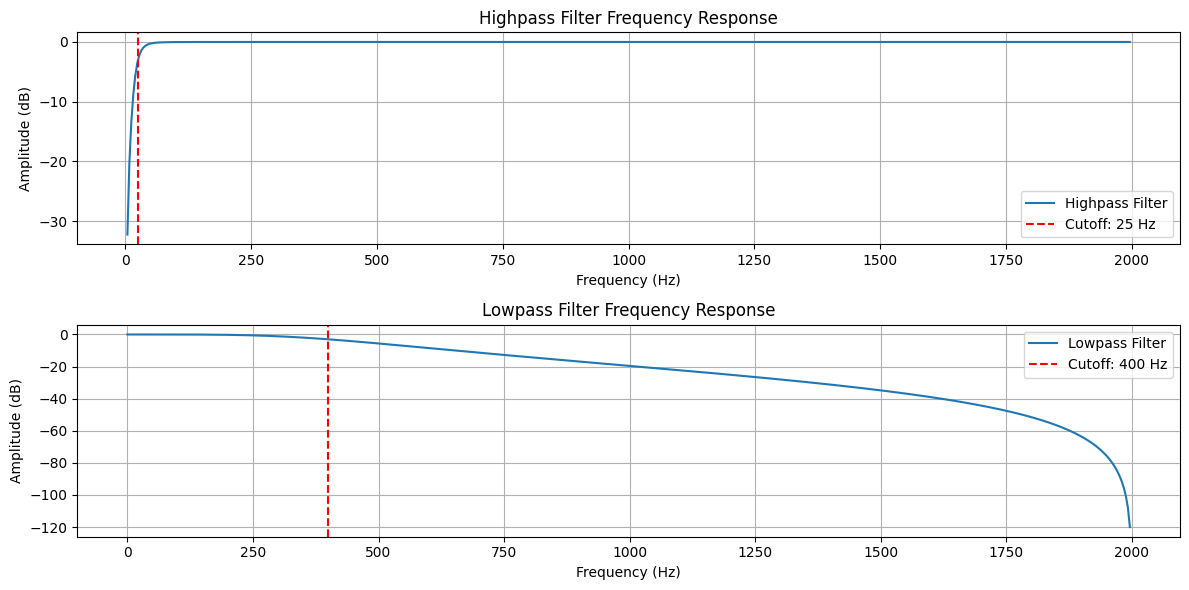

In [8]:
def plot_filter_responses(low_pass_fs, high_pass_fs, sampling_rate=4000, filter_order=2):
    """
    Plots the frequency responses of a highpass and a lowpass Butterworth filter.

    Parameters:
    - low_pass_fs: float, the cutoff frequency for the highpass filter (Hz)
    - high_pass_fs: float, the cutoff frequency for the lowpass filter (Hz)
    - sampling_rate: float, the sampling rate of the signals (Hz)
    - filter_order: int, the order of the Butterworth filter (default is 2)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, sosfreqz

    # Design the highpass filter
    sos_hp = butter(N=filter_order, Wn=low_pass_fs, btype='highpass', analog=False, fs=sampling_rate, output='sos')
    # Design the lowpass filter
    sos_lp = butter(N=filter_order, Wn=high_pass_fs, btype='lowpass', analog=False, fs=sampling_rate, output='sos')

    # Frequency response for the highpass filter
    w_hp, h_hp = sosfreqz(sos_hp, fs=sampling_rate)
    # Frequency response for the lowpass filter
    w_lp, h_lp = sosfreqz(sos_lp, fs=sampling_rate)

    # Plot the frequency response of both filters
    plt.figure(figsize=(12, 6))

    # Plot for the highpass filter
    plt.subplot(2, 1, 1)
    plt.plot(w_hp, 20 * np.log10(np.abs(h_hp)), label='Highpass Filter')
    plt.title('Highpass Filter Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid()
    plt.axvline(low_pass_fs, color='red', linestyle='--', label=f'Cutoff: {low_pass_fs} Hz')
    plt.legend()

    # Plot for the lowpass filter
    plt.subplot(2, 1, 2)
    plt.plot(w_lp, 20 * np.log10(np.abs(h_lp)), label='Lowpass Filter')
    plt.title('Lowpass Filter Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid()
    plt.axvline(high_pass_fs, color='red', linestyle='--', label=f'Cutoff: {high_pass_fs} Hz')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_filter_responses(low_pass_fs=25, high_pass_fs=400)

In [9]:
sample_idx = 1# choose a sample idx
sound = original[sample_idx]['recording']['array']
sampling_rate = original[sample_idx]['recording']['sampling_rate']
sos_hp = scipy.signal.butter(N=2, Wn=45, btype='highpass', analog=False, fs=sampling_rate,
                                     output='sos')
sos_lp = scipy.signal.butter(N=2, Wn=400, btype='lowpass', analog=False, fs=sampling_rate,
                              output='sos')
filtered = scipy.signal.sosfilt(sos_hp, sound)
filtered = scipy.signal.sosfilt(sos_lp, filtered)

## 2.1.2 Denoising -  Averaging Theory
The section of denoising in this tutorial follows [Messer et al.](https://www.sciencedirect.com/science/article/pii/S0026269201000957).


Suppose a Source $\mathbf{S}$ is corrupted additively by i.i.d. Gaussian noise $\epsilon_i$. We observe $\mathbf{X}$ and not $\mathbf{S}$ in our measurements such that:

$$X_i = S + \epsilon_i, i=1,\ldots, N$$

If one computes its variance:

$$\text{Var}\left(\mathbf{S} + \frac{1}{N} \sum_{j=1}^{N}  \epsilon_j\right) = \text{Var}(\mathbf{S}) + \text{Var}\left(\frac{1}{N} \sum_{j=1}^{N}  \epsilon_j \right) = \text{Var}(\mathbf{S}) + \frac{T_i\sigma^2}{N^2}= \text{Var}(\mathbf{S}) + \frac{\sigma^2}{N}$$

one observes that the **standard deviation** of the random terms will shrink as $\frac{\sigma}{\sqrt(N)}$.

Due to the periodic nature of heart sounds and their stationarity (at least in a "short" period of time), we can think of $\mathbf{S}$ to be the expected waveform of the heart cycle in a recording, i.e. the *characteristic heart cycle* of a patient.

## 2.1.3 Wavevet Denoising

In practice, the analysis of a characteristic heartbeat for most downstream
applications is not very useful. Even under (quasi)-stationary assumptions, there may be other phenomena present in the signal such as murmurs that may occur in all states of the heart cycles and across several frequency bands. These phenomena may also be **transient** which immediately defeats the purpose of a characteristic heartbeat.



The Wavelet decomposition will allows us to filter the original signal in an adaptitive way. It allows one to make a trade-off between frequency and time resolution as a function of scale.

The Discrete Wavelet Transform is given by:
$$ \text{DWT}_x^{\psi}(m, n) = \sum_{t} x(t) \psi^*_{m, n}(t) = \sum_{t} x(t) \psi^*\left(\frac{t - n 2^m}{2^m}\right)$$ using a precision of $2^{-m}$, or $m$ bits. $\psi^*$ is the so-called *mother Wavelet function*.

The following code provides visualization of the Haar Wavelet decomposition using 5 levels, i.e. a floating point precision of 5.

We will use the sound you have previously filtered with the butterworth filters for illustrative purposes.





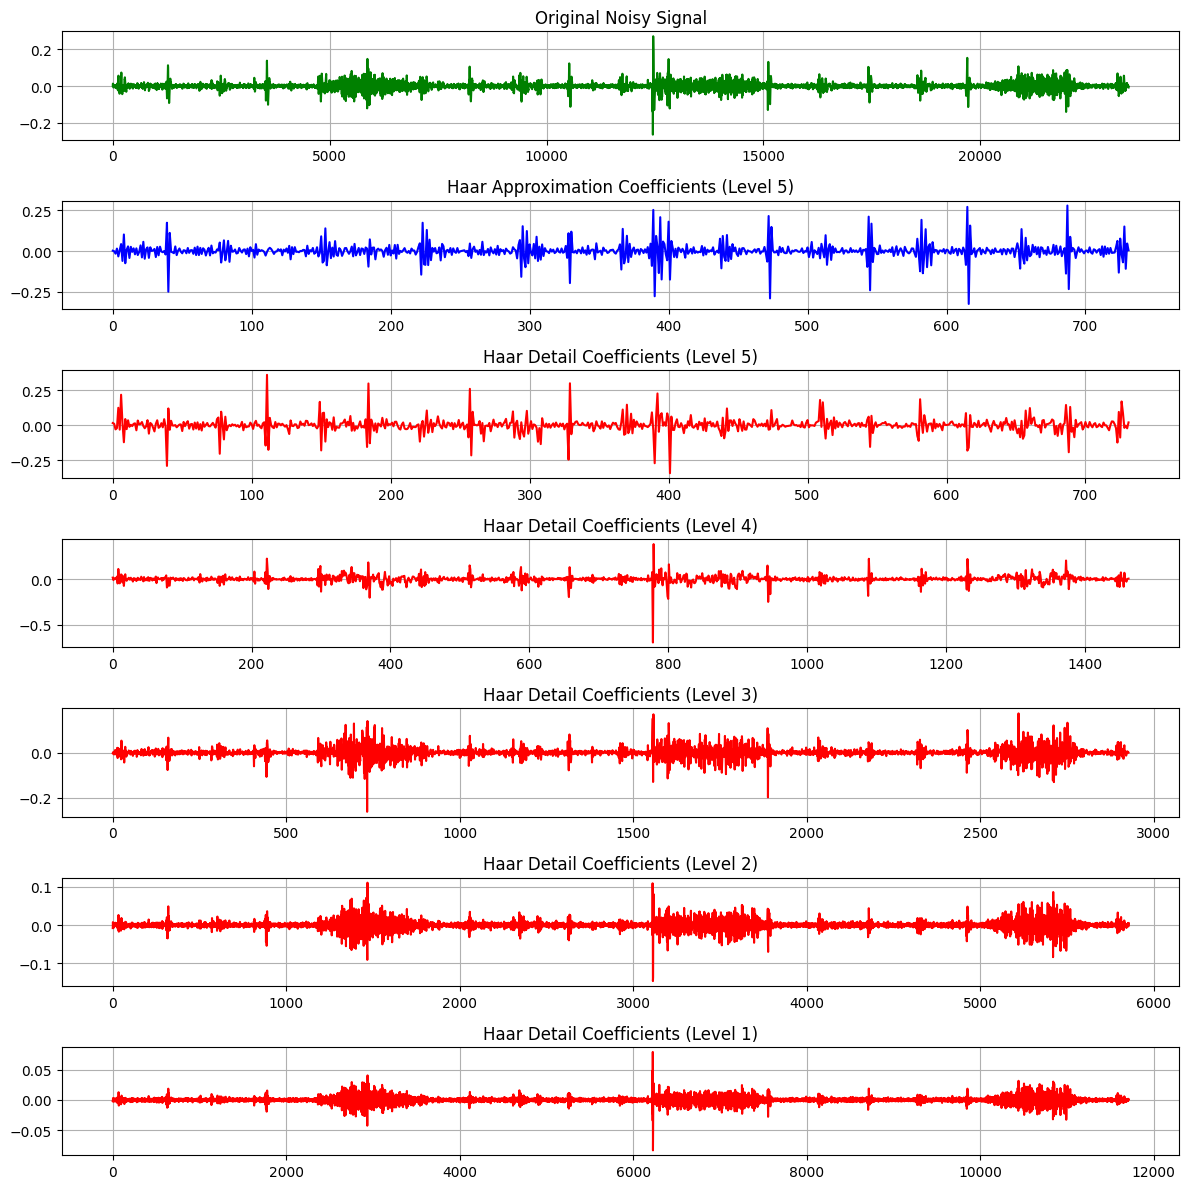

In [10]:

n_levels = 5
coeffs = pywt.wavedec(filtered,
                      wavelet='haar',
                      level=n_levels)
# Plot the original signal alongside the wavelet coefficients
plt.figure(figsize=(12, 12))

# Plot the original noisy signal
plt.subplot(n_levels + 2, 1, 1)
plt.plot(filtered,
         color='green')
plt.title('Original Noisy Signal')
plt.grid(True)

# Plot the approximation coefficients at the highest level
plt.subplot(n_levels + 2, 1, 2)
plt.plot(coeffs[0], color='blue')
plt.title(f'Haar Approximation Coefficients (Level {n_levels})')
plt.grid(True)

# Plot the detail coefficients for each level
for i in range(1, n_levels + 1):
    plt.subplot(n_levels + 2, 1, i + 2)
    plt.plot(coeffs[i], color='red')
    plt.title(f'Haar Detail Coefficients (Level {n_levels - i + 1})')
    plt.grid(True)

plt.tight_layout()
plt.show()


## 2.1.3.a - Universal Thresholding
Since the DWT provides a multiresolution decomposition of the signal, we can use our **prior knowledge** that *most of the information is concentrated in the low frequencies* to mitigate noise in an adaptative fashion. Rembember, we may not want to get rid of all high frequency content necesseraly!



Suppose that the detail coefficients at the **finest scale** are distributed according to a standard Gaussian scaled by $\sigma$. Then, using [extreme value theory](https://nobel.web.unc.edu/wp-content/uploads/sites/13591/2019/11/Gaussian_Extremes-1.pdf), the largest detail coefficient is:

$$\max_{i=1, \ldots, n} |D_i| \approx O(\sigma\sqrt{2\log n})$$

The higher the frequency, the more sensitive to small perturbations our estimates will be, hence we are looking for a robust estimator of $\sigma$. Typically one uses the **median absolute deviation** estimate of the Gaussian:

$$\sigma \approx \frac{\text{median}(|D|)}{0.6745}$$



Now, we only need to define the thresholding function. We will implement the following soft-thresholding:

$$\hat{D}_j = \text{sign}(D_j) \cdot \max(|D_j| - \lambda, 0)$$

where $\lambda = \sigma\sqrt{2\log n}$. This effectively zeroes out coefficients smaller or equal to $\lambda$ and shifts the remaining $D_j$s towards 0 by $\lambda$.


Implement a function that receives the recordings and outputs the a filtered version of the signal. Use `PyWavelets` package to do so, using `pywt.wavedec`to decompose the signal and `pywt.waverec` to reconstruct the signal (after applying universal thresholding to the coefficients).

Run the cell below to see an example

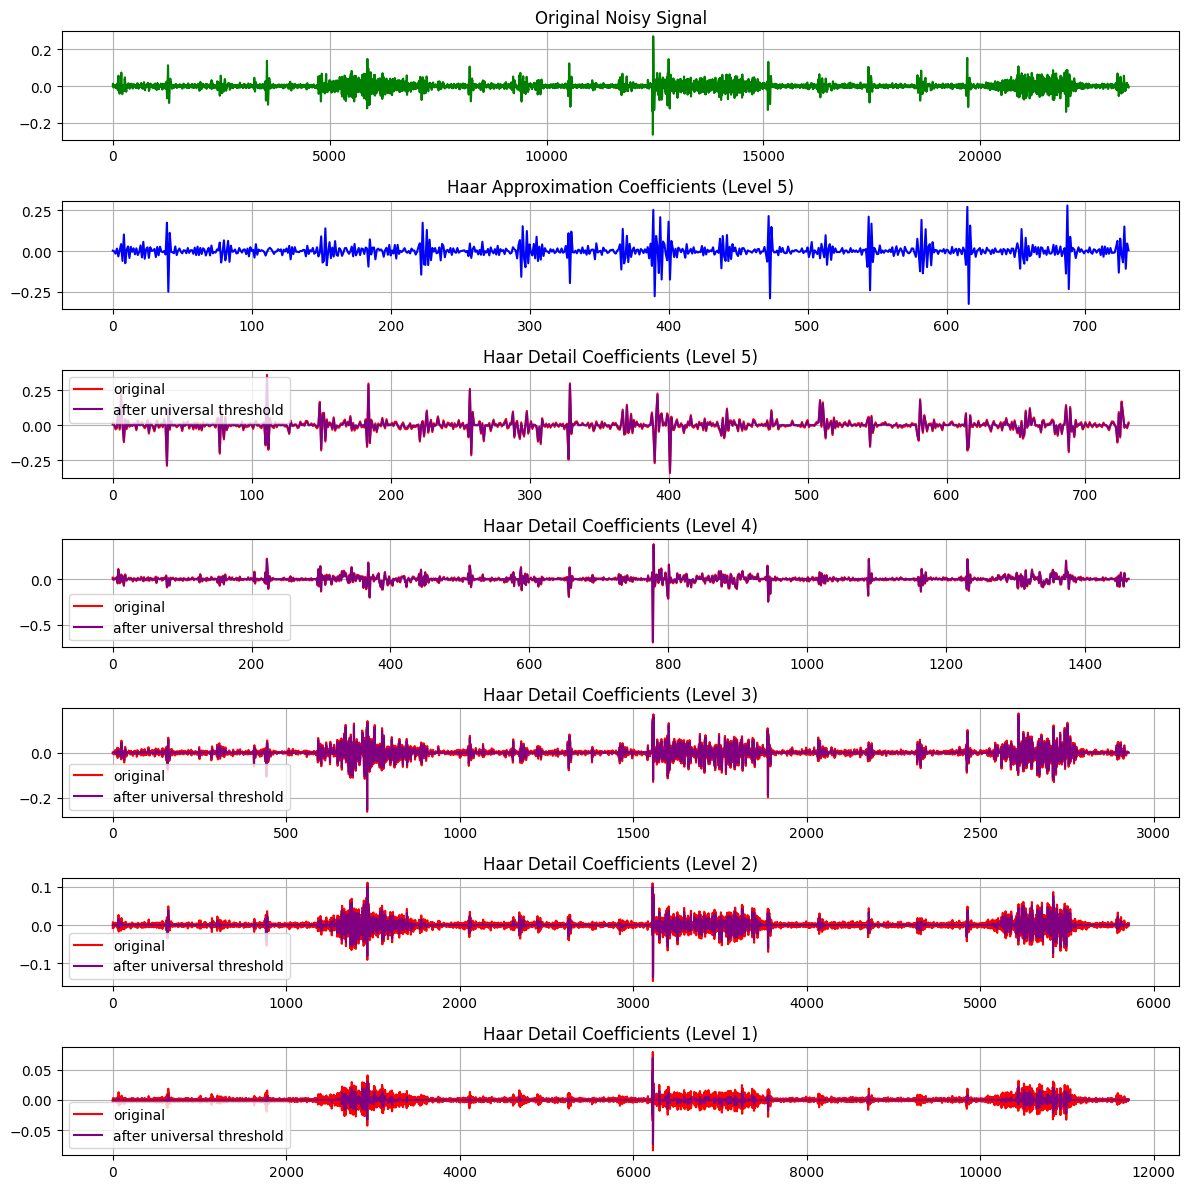

In [11]:
def soft_threshold(coeff, threshold):
        return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

n_levels = 5
coeffs = pywt.wavedec(filtered, wavelet='haar', level=n_levels)
# Plot the original signal alongside the wavelet coefficients
plt.figure(figsize=(12, 12))

# Define a threshold value (e.g., universal threshold)
sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Estimating noise level
threshold = sigma * np.sqrt(2 * np.log(len(filtered)))

# Apply soft thresholding to the detail coefficients
coeffs_thresholded = [coeffs[0]]  # Keep approximation coefficients unchanged
for coeff in coeffs[1:]:
    coeffs_thresholded.append(soft_threshold(coeff, threshold))


# Plot the original noisy signal
plt.subplot(n_levels + 2, 1, 1)
plt.plot(filtered, color='green')
plt.title('Original Noisy Signal')
plt.grid(True)

# Plot the approximation coefficients at the highest level
plt.subplot(n_levels + 2, 1, 2)
plt.plot(coeffs[0], color='blue')
plt.title(f'Haar Approximation Coefficients (Level {n_levels})')
plt.grid(True)

# Plot the detail coefficients for each level
for i in range(1, n_levels + 1):
    plt.subplot(n_levels + 2, 1, i + 2)
    plt.plot(coeffs[i], color='red', label='original')
    plt.plot(coeffs_thresholded[i], color='purple', label='after universal threshold')
    plt.title(f'Haar Detail Coefficients (Level {n_levels - i + 1})')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## 2.2 - Visualize the original vs processed waveforms
Run the cell below to see how our signal-processing strategy affects the waveform.

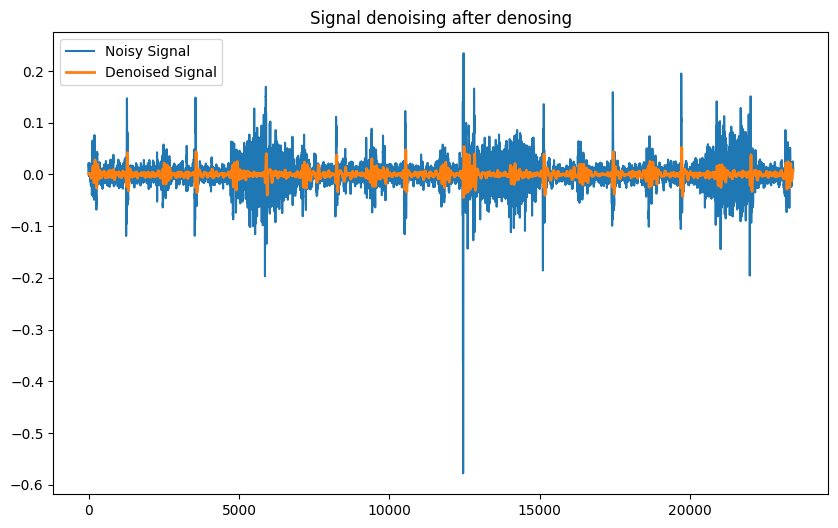

In [12]:
def plot_denoised_signal(dataset, denoised_sounds, sample_idx):
    noisy_signal = dataset[sample_idx]['recording']['array']
    denoised_signal = denoised_sounds[sample_idx]['recording']['array']
    plt.figure(figsize=(10, 6))
    plt.plot(noisy_signal, label='Noisy Signal')
    plt.plot(denoised_signal, label='Denoised Signal', linewidth=2)
    plt.legend()
    plt.title(f'Signal denoising after denosing')
    plt.show()

# Inspect the results on a sample
sample_idx = 1 # choose sample idx
plot_denoised_signal(original, processed, sample_idx)

# Part 2 - Deep Learning and Model serving

We have prepared a set of files with a set of features pre-extracted from the processed dataset.

Specifically, we extracted amplitude and homomorphic envelograms and subsample the signals to from 4000 Hz to 50 Hz.

Details can be found on most papers in the literature such as [this one](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10242001).

In [13]:
dataset_dict = load_dataset("miguellmartins/circor-digiscope-physionet22-tutorial")

In [14]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['filename', 'recording', 'recording_label', 'heart_state_labels', 'amplitude_env', 'homomorphic_env', 'identifier'],
        num_rows: 2683
    })
    dev: Dataset({
        features: ['filename', 'recording', 'recording_label', 'heart_state_labels', 'amplitude_env', 'homomorphic_env', 'identifier'],
        num_rows: 337
    })
    val: Dataset({
        features: ['filename', 'recording', 'recording_label', 'heart_state_labels', 'amplitude_env', 'homomorphic_env', 'identifier'],
        num_rows: 343
    })
})


We will be using a patch size $P$ of samples, so for a sample rate of 50Hz, the window spans roughly 1.3 seconds.

We will processing the sounds patch-by-patch, so we will be discarding recordings that do not span at least one patch $P$.

Run the following code to apply these steps to each dataset.

Note that if you have more than 2 envelograms from Tutorial 1 you need to change `nch` (i.e., number of channels) accordingly.

We recommend starting with `stride=32`, but you can revisit this part of the tutorial later and adapt all parameters to your liking.

In [15]:
PATCH_SIZE = 64
NUMBER_CHANNELS = 2
NUMBER_CLASSES = 4
STRIDE = 32
BATCH_SIZE = 32

Some of the sounds might be too short for the above configuration. We will have to preemptively filter them before we move forward with training.

In [16]:
def filter_datasets(dataset_dict: DatasetDict, patch_size: int = 64):
  _filter_small = lambda x: len(x) >= patch_size
  for split in dataset_dict:
    # We only to feature by one of the envelopes since they both have same length
    dataset_dict[split] = dataset_dict[split].filter(lambda x: len(x['amplitude_env']) >= patch_size)
  return dataset_dict


dataset_dict = filter_datasets(dataset_dict)

The heart state labels are also ordinal. We will be changing the enconding to one-hot.

In [17]:
def one_hot_encoding(num_classes: int = 4):
  one_hot_labels = np.eye(num_classes)
  def _one_hot_encoding(example):
    example["heart_state_labels"] = one_hot_labels[np.array(example['heart_state_labels']) - 1]
    return example
  return _one_hot_encoding


for split in dataset_dict:
  dataset_dict[split] = dataset_dict[split].map(one_hot_encoding(num_classes=NUMBER_CLASSES))

The U-Net takes as input patches of a given size $P$.
Note that our sounds are downsampled to 50Hz by now (80$\times$ smaller than the original 4KHz). However, loading all sound patches, especially if they overlap, may have unrealistic V-RAM requirements for most scenarios.

With that in mind, we will have to compute our sound patches dynamically, i.e. online during training or inference.

We make use of the [HuggingFace Dataset API](https://huggingface.co/docs/hub/datasets-overview) to build a streamable dataset that can than be instantiated as a [TensorFlow Dataset](https://www.tensorflow.org/guide/data) to serve our U-Net.
Please inspect the following class `PatchIterableDataset` which will handle all the [ETL](https://tinyurl.com/527fak67) for our deep learning data pipeline.

Generators use the yield statement to produce a series of values, "pausing" the function each time a yield is encountered and resuming the execution in the next iteration. This makes them memory-efficient because they only produce items as needed, unlike lists that store all items in memory. Naturally, this solution is slower than pre-computing all patches.

In [18]:
import numpy as np
import torch
from torch.utils.data import IterableDataset, DataLoader
LEN_PATCHES = 46689
class PatchIterableDataset(IterableDataset):
    """
    Iterates over a Hugging Face dataset, chunking frames into (patch_size, 2).
    Does NOT store the entire dataset in memory, only a buffer of length patch_size.
    """
    def __init__(self, hf_dataset,
                 patch_size: int,
                 stride: int):
        """
        Args:
            hf_dataset: A Hugging Face (Iterable)Dataset or anything else iterable
                        where each item is a dict with 'features' -> shape (T_i, 2).
            patch_size: Number of frames to accumulate before yielding a chunk.
            drop_incomplete_chunk: If True, discard leftover frames if they're
                                   less than patch_size at the end.
        """
        super().__init__()
        self.dataset = hf_dataset
        self.patch_size = patch_size
        self.stride = stride

    def __len__(self):
        return LEN_PATCHES
    
    def __iter__(self):
        buffer = []
        # Stream over the original dataset, example by example:
        for example in self.dataset:
            amp_env, homo_env, label = example['amplitude_env'], example['homomorphic_env'], example['heart_state_labels']
            amp_env = np.array(amp_env)
            homo_env = np.array(homo_env)
            label = np.array(label)
                # Combine the two feature columns along a new dimension => shape: (time, 2)
            num_samples = len(homo_env)
            sound = np.stack([amp_env, homo_env], axis=-1)
            num_windows = int((num_samples - self.patch_size) / self.stride) + 1
            for window_idx in range(num_windows):
                patch_start = window_idx * self.stride
                yield sound[patch_start:patch_start + self.patch_size, :].T, label[patch_start: patch_start + self.patch_size, :].T

            window_remain = num_samples - self.patch_size
            if window_remain % self.stride > 0:
                yield sound[window_remain:, :].T, label[window_remain:, :].T

In [19]:
patch_dataset_train = PatchIterableDataset(dataset_dict['train'],
                                           patch_size=PATCH_SIZE,
                                           stride=STRIDE)

patch_dataset_dev = PatchIterableDataset(dataset_dict['dev'],
                                           patch_size=PATCH_SIZE,
                                           stride=STRIDE)

patch_dataset_val = PatchIterableDataset(dataset_dict['val'],
                                           patch_size=PATCH_SIZE,
                                           stride=STRIDE)

Run the following code to create the Tensorflow Dataset objects using our custom data generator. We will be using `.cache()` and `.prefetch()` from the [tf.Data API](https://www.tensorflow.org/guide/data_performance) to minimize the overhead of computing each batch of data online.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall
import os

# -----------------------------
# 1. U-Net Model in PyTorch
# -----------------------------
class ExampleUNet(nn.Module):
    def __init__(self, patch_size, nch, dropout=0.0):
        super(ExampleUNet, self).__init__()
        
        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv1d(nch, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.up_prep = nn.Sequential(
            nn.ConvTranspose1d(16, 8, kernel_size=2, stride=2),  # Upsampling equivalent
        )
        self.drop_up = nn.Dropout(p=dropout)
        
        self.conv_up = nn.Sequential(
            nn.Conv1d(16, 8, kernel_size=3, padding=1),  # 8 (from up) + 8 (skip) = 16
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.output_layer = nn.Conv1d(8, 4, kernel_size=1)  # 4 classes
        self.softmax = nn.Softmax(dim=1)  # Apply in forward if needed

    def forward(self, x):
        # x shape: (batch_size, nch, patch_size)
        
        # Encoder
        conv1 = self.conv1(x)           # -> (B, 8, patch_size)
        pool1 = self.pool1(conv1)       # -> (B, 8, patch_size//2)
        pool1 = self.drop1(pool1)
        
        conv2 = self.conv2(pool1)       # -> (B, 16, patch_size//2)
        
        # Decoder
        up_prep = self.up_prep(conv2)   # -> (B, 8, patch_size)
        
        # Skip connection: conv1 is (B, 8, patch_size), up_prep is (B, 8, patch_size)
        up = torch.cat([up_prep, conv1], dim=1)  # -> (B, 16, patch_size)
        up = self.drop_up(up)
        
        convout = self.conv_up(up)      # -> (B, 8, patch_size)
        output = self.output_layer(convout)  # -> (B, 4, patch_size)
        
        # Softmax along channel dimension (for multi-class per position)
        output = self.softmax(output)
        
        return output

# -----------------------------
# 2. Model Instantiation
# -----------------------------
PATCH_SIZE = 64
NUMBER_CHANNELS = 2
NUMBER_CLASSES = 4
STRIDE = 32
BATCH_SIZE = 32

model = ExampleUNet(patch_size=PATCH_SIZE, nch=NUMBER_CHANNELS, dropout=0.0)
print(model)

# Print model summary (using torchinfo or manual)
try:
    from torchinfo import summary
    summary(model, input_size=(1, NUMBER_CHANNELS, PATCH_SIZE))
except ImportError:
    print("Install torchinfo for detailed summary: pip install torchinfo")

# -----------------------------
# 3. Loss, Optimizer, Metrics
# -----------------------------
criterion = nn.CrossEntropyLoss()  # Expects (B, C, L), target (B, L) with class indices
optimizer = optim.Adam(model.parameters(), lr=1e-4)



# Move model to GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = model.to(device)

# Metrics (using torchmetrics)
accuracy = Accuracy(task='multiclass', num_classes=4, average='macro').to(device)
precision = Precision(task='multiclass', num_classes=4, average='macro').to(device)
recall = Recall(task='multiclass', num_classes=4, average='macro').to(device)
# -----------------------------
# 4. Training Loop with Checkpointing
# -----------------------------
EPOCHS = 50
checkpoint_path = 'unet_weights/unet.pth'
os.makedirs('unet_weights', exist_ok=True)

best_val_loss = float('inf')

# Dummy data loader (replace with your actual DataLoader)
train_loader = DataLoader(patch_dataset_train, batch_size=32)
val_loader = DataLoader(patch_dataset_dev, batch_size=32)

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device, dtype=torch.float32)      # (B, nch, patch_size)
        targets = targets.to(device, dtype=torch.float32)       # (B, patch_size) with class indices [0-3]
        
        optimizer.zero_grad()
        outputs = model(inputs)         # (B, 4, patch_size)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def validate(epoch):
    model.eval()
    val_loss = 0.0
    accuracy.reset()
    precision.reset()
    recall.reset()
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            # Convert outputs to class predictions
            preds = torch.argmax(outputs, dim=1)  # (B, patch_size)
            targets = torch.argmax(targets, dim=1)
            accuracy.update(preds, targets)
            recall.update(preds, targets)
    
    avg_val_loss = val_loss / len(val_loader)
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    
    print(f"Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
    return avg_val_loss

# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(epoch)
    print(train_loss)
    val_loss = validate(epoch)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"New best model saved to {checkpoint_path}")

print("Training complete!")

ExampleUNet(
  (conv1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (up_prep): Sequential(
    (0): ConvTranspose1d(16, 8, kernel_size=(2,), stride=(2,))
  )
  (drop_up): Dropout(p=0.0, inplace=False)
  (conv_up): Sequential(
    (0): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (output_layer): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
  (softmax): Softmax(dim=1)
)
Install torchinfo for detailed summary: pip inst

/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1496 | Acc: 0.4732 | Prec: 0.0000 | Rec: 0.4732
New best model saved to unet_weights/unet.pth

Epoch 2/50
1.1626436066137602


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1436 | Acc: 0.5613 | Prec: 0.0000 | Rec: 0.5613
New best model saved to unet_weights/unet.pth

Epoch 3/50
1.1210012639630331


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1400 | Acc: 0.5974 | Prec: 0.0000 | Rec: 0.5974
New best model saved to unet_weights/unet.pth

Epoch 4/50
1.0964124595873976


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1379 | Acc: 0.6165 | Prec: 0.0000 | Rec: 0.6165
New best model saved to unet_weights/unet.pth

Epoch 5/50
1.0835348306453392


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1366 | Acc: 0.6266 | Prec: 0.0000 | Rec: 0.6266
New best model saved to unet_weights/unet.pth

Epoch 6/50
1.0747068786457794


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1356 | Acc: 0.6360 | Prec: 0.0000 | Rec: 0.6360
New best model saved to unet_weights/unet.pth

Epoch 7/50
1.0663120946247284


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1346 | Acc: 0.6442 | Prec: 0.0000 | Rec: 0.6442
New best model saved to unet_weights/unet.pth

Epoch 8/50
1.0573906726216618


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1334 | Acc: 0.6532 | Prec: 0.0000 | Rec: 0.6532
New best model saved to unet_weights/unet.pth

Epoch 9/50
1.0497077605903966


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1325 | Acc: 0.6606 | Prec: 0.0000 | Rec: 0.6606
New best model saved to unet_weights/unet.pth

Epoch 10/50
1.043760173655536


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1318 | Acc: 0.6667 | Prec: 0.0000 | Rec: 0.6667
New best model saved to unet_weights/unet.pth

Epoch 11/50
1.0389530417853838


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1312 | Acc: 0.6718 | Prec: 0.0000 | Rec: 0.6718
New best model saved to unet_weights/unet.pth

Epoch 12/50
1.034856063249993


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1307 | Acc: 0.6764 | Prec: 0.0000 | Rec: 0.6764
New best model saved to unet_weights/unet.pth

Epoch 13/50
1.0311989393136272


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1302 | Acc: 0.6810 | Prec: 0.0000 | Rec: 0.6810
New best model saved to unet_weights/unet.pth

Epoch 14/50
1.027923582718797


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1298 | Acc: 0.6849 | Prec: 0.0000 | Rec: 0.6849
New best model saved to unet_weights/unet.pth

Epoch 15/50
1.0250201115869495


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1295 | Acc: 0.6880 | Prec: 0.0000 | Rec: 0.6880
New best model saved to unet_weights/unet.pth

Epoch 16/50
1.0224342073887995


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1292 | Acc: 0.6908 | Prec: 0.0000 | Rec: 0.6908
New best model saved to unet_weights/unet.pth

Epoch 17/50
1.0201804813865112


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1289 | Acc: 0.6932 | Prec: 0.0000 | Rec: 0.6932
New best model saved to unet_weights/unet.pth

Epoch 18/50
1.01816105087326


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1287 | Acc: 0.6953 | Prec: 0.0000 | Rec: 0.6953
New best model saved to unet_weights/unet.pth

Epoch 19/50
1.0163112260299185


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1285 | Acc: 0.6970 | Prec: 0.0000 | Rec: 0.6970
New best model saved to unet_weights/unet.pth

Epoch 20/50
1.014653554191328


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1283 | Acc: 0.6983 | Prec: 0.0000 | Rec: 0.6983
New best model saved to unet_weights/unet.pth

Epoch 21/50
1.0132042158956398


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1282 | Acc: 0.6997 | Prec: 0.0000 | Rec: 0.6997
New best model saved to unet_weights/unet.pth

Epoch 22/50
1.011906947011817


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1280 | Acc: 0.7008 | Prec: 0.0000 | Rec: 0.7008
New best model saved to unet_weights/unet.pth

Epoch 23/50
1.0107204002468553


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1279 | Acc: 0.7020 | Prec: 0.0000 | Rec: 0.7020
New best model saved to unet_weights/unet.pth

Epoch 24/50
1.0096236065234223


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1278 | Acc: 0.7029 | Prec: 0.0000 | Rec: 0.7029
New best model saved to unet_weights/unet.pth

Epoch 25/50
1.0086107623087217


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1277 | Acc: 0.7037 | Prec: 0.0000 | Rec: 0.7037
New best model saved to unet_weights/unet.pth

Epoch 26/50
1.0076638086609644


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1276 | Acc: 0.7047 | Prec: 0.0000 | Rec: 0.7047
New best model saved to unet_weights/unet.pth

Epoch 27/50
1.0067690781126284


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1275 | Acc: 0.7056 | Prec: 0.0000 | Rec: 0.7056
New best model saved to unet_weights/unet.pth

Epoch 28/50
1.0059378630494418


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1274 | Acc: 0.7063 | Prec: 0.0000 | Rec: 0.7063
New best model saved to unet_weights/unet.pth

Epoch 29/50
1.0051405571094931


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1273 | Acc: 0.7070 | Prec: 0.0000 | Rec: 0.7070
New best model saved to unet_weights/unet.pth

Epoch 30/50
1.0043900732308217


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1273 | Acc: 0.7075 | Prec: 0.0000 | Rec: 0.7075
New best model saved to unet_weights/unet.pth

Epoch 31/50
1.0036860003046792


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1272 | Acc: 0.7082 | Prec: 0.0000 | Rec: 0.7082
New best model saved to unet_weights/unet.pth

Epoch 32/50
1.003011771424176


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1271 | Acc: 0.7085 | Prec: 0.0000 | Rec: 0.7085
New best model saved to unet_weights/unet.pth

Epoch 33/50
1.0023775354640125


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1271 | Acc: 0.7089 | Prec: 0.0000 | Rec: 0.7089
New best model saved to unet_weights/unet.pth

Epoch 34/50
1.0017729289727668


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1270 | Acc: 0.7094 | Prec: 0.0000 | Rec: 0.7094
New best model saved to unet_weights/unet.pth

Epoch 35/50
1.0011833766960119


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1270 | Acc: 0.7098 | Prec: 0.0000 | Rec: 0.7098
New best model saved to unet_weights/unet.pth

Epoch 36/50
1.0006224429770691


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1269 | Acc: 0.7102 | Prec: 0.0000 | Rec: 0.7102
New best model saved to unet_weights/unet.pth

Epoch 37/50
1.0000943484779907


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1269 | Acc: 0.7104 | Prec: 0.0000 | Rec: 0.7104
New best model saved to unet_weights/unet.pth

Epoch 38/50
0.9995859949556115


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1268 | Acc: 0.7108 | Prec: 0.0000 | Rec: 0.7108
New best model saved to unet_weights/unet.pth

Epoch 39/50
0.9990987078784264


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1268 | Acc: 0.7112 | Prec: 0.0000 | Rec: 0.7112
New best model saved to unet_weights/unet.pth

Epoch 40/50
0.9986288746334102


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1267 | Acc: 0.7115 | Prec: 0.0000 | Rec: 0.7115
New best model saved to unet_weights/unet.pth

Epoch 41/50
0.9981769342945047


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1267 | Acc: 0.7119 | Prec: 0.0000 | Rec: 0.7119
New best model saved to unet_weights/unet.pth

Epoch 42/50
0.9977449972743857


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1267 | Acc: 0.7122 | Prec: 0.0000 | Rec: 0.7122
New best model saved to unet_weights/unet.pth

Epoch 43/50
0.9973233318900409


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1266 | Acc: 0.7123 | Prec: 0.0000 | Rec: 0.7123
New best model saved to unet_weights/unet.pth

Epoch 44/50
0.99691485913649


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1266 | Acc: 0.7125 | Prec: 0.0000 | Rec: 0.7125
New best model saved to unet_weights/unet.pth

Epoch 45/50
0.9965062113657389


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1266 | Acc: 0.7128 | Prec: 0.0000 | Rec: 0.7128
New best model saved to unet_weights/unet.pth

Epoch 46/50
0.9961079835891724


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1265 | Acc: 0.7129 | Prec: 0.0000 | Rec: 0.7129
New best model saved to unet_weights/unet.pth

Epoch 47/50
0.9957054023056814


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1265 | Acc: 0.7132 | Prec: 0.0000 | Rec: 0.7132
New best model saved to unet_weights/unet.pth

Epoch 48/50
0.9953007930762148


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1264 | Acc: 0.7133 | Prec: 0.0000 | Rec: 0.7133
New best model saved to unet_weights/unet.pth

Epoch 49/50
0.9949174645828874


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Val Loss: 0.1264 | Acc: 0.7138 | Prec: 0.0000 | Rec: 0.7138
New best model saved to unet_weights/unet.pth

Epoch 50/50
0.994555502680883
Val Loss: 0.1264 | Acc: 0.7145 | Prec: 0.0000 | Rec: 0.7145
New best model saved to unet_weights/unet.pth
Training complete!


/Users/miguelmartins/projects/tutorial/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Introduced by [Ronneberg et al.](https://arxiv.org/abs/1505.04597) in 2015, the U-Net is ubiquitous in biomedical signal and image processing tasks.

Although its efficacy is a result of several advancements of modern deep learning and optimization techniques, one of its characteristic architetural patterns are the skip connections from the encoder to the decoder.

The idea is that low-resolution information is important for medical domains, which can be complementary to the semantical rich features in the decoder.

Inspect and run the code below of a template for a simple U-Net adapted to process signals instead of images; using 1D instead of 2D primitives.

Instantiate your U-Net model and select a set of adequate metrics to track.

Early stopping on validation set is performed using `ModelCheckpoint` on `val_loss`.

We will be using the Adam Gradient Descent algorithm.
If you have access to a GPU run this code for 50 epochs.
If not, 10 epochs should still give you a sufficiently capable model to complete this tutorial

Let us perform inference on the external validation dataset.

In [35]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval() 
outputs = []
test_loader = DataLoader(patch_dataset_val, batch_size=32)
with torch.no_grad():
    for data, target in test_loader:  # assuming you have a test_loader
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.float32)
        output = model(data)
        outputs.append(output.cpu())

outputs = torch.cat(outputs, dim=0)
outputs = outputs.permute(0, 2, 1)
print(outputs.shape)


torch.Size([5332, 64, 4])


`predictions_test` has the predictions on the test-set patch-wise in a patient agnostic fashion.

We now need to associate the appropriate outputs for each recording in an adequate fashion. Moreover, the fact that we used an overalpping slidding window means that we will have several heart state estimates for a given time $t$.

We will be averaging the U-Net's predictions across the patch dimension. The strategy resembles the `__iter__` method of `PatchIterableDataset`. Let $N_{P_i} = \lceil  \frac{T_i - P}{\tau} \rceil$

$$\tilde{\mathbf{y}}_i(t, \tau) = \frac{1}{N_{P_i}}\sum_{t=1}^{N_{P_i}} \text{U-Net}(\mathbf{x}_i(t, \tau)| \theta^*)$$
So $\tilde{\mathbf{y}}_i$ should have shape $(T_i, 4)$.

Inspect the function `process_unet_predictions`. It should return the predicted label sequence (in ordinal form, not one-hot-encoded), and the corresponding probabilty estimates.

In [47]:
def process_unet_predictions(preds, dataframe, patch_size, stride):
  num_observations = len(dataframe)
  output_probs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  output_seqs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  preds_idx = 0
  for idx, sample in tqdm(enumerate(dataframe)):
    sound = sample['heart_state_labels']
    sound_duration = len(sound)
    # number of patches associated to this sound
    number_patches = int((sound_duration - patch_size) / stride)
    if (sound_duration - patch_size) % stride > 0:
      number_patches += 1
    prob_sound = np.zeros((number_patches, sound_duration, 4))
    for i in range(number_patches):
      prob_sound[i, i * stride:i * stride + patch_size, :] = preds[preds_idx, :, :]
      preds_idx += 1
    if (sound_duration - patch_size) % stride > 0:
      prob_sound[number_patches - 1, sound_duration - patch_size:, :] = preds[preds_idx, :, :]
      preds_idx +=1

    probs_patch = np.sum(prob_sound, axis=0)
    probs_patch_normalized = probs_patch /  (np.sum(prob_sound, axis=(0,2))[:, np.newaxis] + 1e-12)
    output_probs[idx] = probs_patch_normalized
    output_seqs[idx] = np.argmax(probs_patch_normalized, axis=1)
  return output_probs, output_seqs

In [48]:
probs, predictions = process_unet_predictions(outputs, dataset_dict['val'], PATCH_SIZE, STRIDE)

325it [00:00, 634.88it/s]


The U-Net outputs estimates patch-by-patch, meaning it can output invalid heart sequences, e.g. going from S1 directly to S2 (we are assuming that screening is not interrupted here).

Implement a deconding function that takes the sequence predicted patch-by-patch that you recovered using `process_unet_predictions` and processes the output to be valid. You can change the output according to any criteria you want.

The function you implement should pass the unit test in the cell bellow.

In [55]:
def your_deconding_function(seq, num_states=4):
    for i in range(1, len(seq)):
        if ((seq[i-1] + 1) % num_states != seq[i]) and (seq[i] != seq[i-1]):
            seq[i] = seq[i-1]
    return seq

test_seq = np.array([1, 1, 1, 2, 1, 1, 2, 2, 3, 3, 0, 3])
exp_seq = np.array([1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 0])

out_seq = your_deconding_function(test_seq)
assert np.all(exp_seq == out_seq)

In [57]:
from tqdm import tqdm
test_labels = dataset_dict['val']['heart_state_labels']
ground_truth = np.array([np.argmax(y, axis=1) for y in tqdm(test_labels)], dtype=object)
predictions = np.array([your_deconding_function(prediction) for prediction in predictions], dtype=object)

100%|███████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 1422.82it/s]


We will follow [Schmidt et al.](https://iopscience.iop.org/article/10.1088/0967-3334/31/4/004/pdf). A sound is true positive (TP) or correctly located if
the middle of the detected sound is closer than 60 ms to the middle of a similarly predefined sound, all other detected sounds were defined as false positive (FP).

Sensitivity is defined as:
\begin{equation}
\text{Sensitivity} = \frac{\text{number of TP sounds}}{\text{total number of S1 and S2 sounds}}
\end{equation}

and positive predictivity ($P_+$):
\begin{equation}
P_+ = \frac{\text{number of TP sounds}}{\text{number of TP sounds} + \text{number of FP sounds}}.
\end{equation}

These metrics are tricky to implement so we provide them beforehand (the authors may or may not had a little help from o1-preview for this step :))

In [58]:
import numpy as np
from sklearn.metrics import accuracy_score
def extract_state_runs(labels, desired_states):
    """
    Extract continuous runs of the desired states from labels.

    Args:
        labels: numpy array of labels.
        desired_states: set of desired state values.

    Returns:
        A list of dictionaries with keys:
            'start': start index of the run
            'end': end index of the run (inclusive)
            'midpoint': midpoint index of the run
            'state': the state value (0 or 2)
    """
    # Ensure labels is a 1D array
    labels = np.asarray(labels).flatten()

    runs = []
    N = len(labels)
    in_run = False
    run_start = 0
    run_state = None

    for i in range(N):
        label_i = labels[i]
        # If label_i is an array (e.g., from a structured array), extract scalar
        if isinstance(label_i, np.ndarray):
            label_i = label_i.item()
        if label_i in desired_states:
            if not in_run:
                # Start of a new run
                in_run = True
                run_start = i
                run_state = label_i
        else:
            if in_run:
                # End of the run
                run_end = i - 1
                midpoint = (run_start + run_end) // 2
                runs.append({
                    'start': run_start,
                    'end': run_end,
                    'midpoint': midpoint,
                    'state': run_state
                })
                in_run = False
                run_state = None
    # Check if we're still in a run at the end
    if in_run:
        run_end = N - 1
        midpoint = (run_start + run_end) // 2
        runs.append({
            'start': run_start,
            'end': run_end,
            'midpoint': midpoint,
            'state': run_state
        })
    return runs

def compute_ppv_sensitivity(ground_truth, predictions, sample_rate, threshold=60e-3):
    """
    Compute PPV and sensitivity for states 0 and 2.

    Args:
        ground_truth: numpy array of ground truth labels.
        predictions: numpy array of predicted labels.
        sample_rate: sampling rate in Hz.

    Returns:
        ppv: Positive Predictive Value.
        sensitivity: Sensitivity (Recall).
    """
    # Ensure ground_truth and predictions are 1D arrays
    ground_truth = np.asarray(ground_truth).flatten()
    predictions = np.asarray(predictions).flatten()

    # Desired states
    desired_states = {0, 2}

    # Maximum distance in samples (treshold in seconds vs fs)
    max_distance_samples = int(threshold * sample_rate)

    # Extract runs from ground truth and predictions
    gt_runs = extract_state_runs(ground_truth, desired_states)
    pred_runs = extract_state_runs(predictions, desired_states)

    # Get midpoints and states
    gt_midpoints = np.array([run['midpoint'] for run in gt_runs])
    gt_states = np.array([run['state'] for run in gt_runs])

    pred_midpoints = np.array([run['midpoint'] for run in pred_runs])
    pred_states = np.array([run['state'] for run in pred_runs])

    # Initialize matches
    matched_gt_indices = set()
    matched_pred_indices = set()

    # Build potential matches
    potential_matches = []
    for i, (p_mid, p_state) in enumerate(zip(pred_midpoints, pred_states)):
        for j, (gt_mid, gt_state) in enumerate(zip(gt_midpoints, gt_states)):
            if gt_state == p_state:
                distance = abs(p_mid - gt_mid)
                if distance <= max_distance_samples:
                    potential_matches.append((i, j, distance))

    # Sort potential matches by distance
    potential_matches.sort(key=lambda x: x[2])

    # Perform matching
    TP = 0
    for i, j, d in potential_matches:
        if i not in matched_pred_indices and j not in matched_gt_indices:
            matched_pred_indices.add(i)
            matched_gt_indices.add(j)
            TP += 1

    # Compute FP and FN
    total_pred = len(pred_midpoints)
    total_gt = len(gt_midpoints)
    FP = total_pred - len(matched_pred_indices)
    FN = total_gt - len(matched_gt_indices)

    # Compute PPV and Sensitivity
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    return ppv, sensitivity

In [59]:
def compute_schmidt_metrics(ground_truth, sequences, sampling_rate):
  ppvs, sensitivities, accuracies = [], [], []
  for i in tqdm(range(len(ground_truth))):
    ppv, sensitivity = compute_ppv_sensitivity(ground_truth[i],
                                               sequences[i],
                                               sampling_rate)
    ppvs.append(ppv)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy_score(ground_truth[i], sequences[i]))
  return np.array(ppvs), np.array(sensitivities), np.array(accuracies)


ppv, sens, acc = compute_schmidt_metrics(ground_truth, predictions, sampling_rate=50)

100%|███████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 2770.43it/s]


In [64]:
np.mean(ppv), np.mean(sens), np.mean(acc)

(np.float64(0.29492277864171484),
 np.float64(0.22080745237898305),
 np.float64(0.30364236441851256))

Inspect a result where your metrics had satisfactory performance and one where the result was less positive. Discuss the differences.

In [65]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(ground_truth, seqs, idx):

  # Define the window width in terms of seconds and convert to the corresponding sample range
  window_duration = 0.1  # 0.06 ms in seconds
  sample_interval = 1 / 50  # Time per sample in seconds (20 ms per sample at 50 Hz)

  # Calculate the equivalent width in terms of sample indices (will be <1)
  window_width_samples = window_duration / sample_interval

  # Create the plot
  plt.figure(figsize=(24, 6))

  # Plot ground truth and predictions with discrete markers and dotted lines
  plt.plot(ground_truth[idx], 'o--', label='Ground Truth', markersize=6)
  plt.plot(seqs[idx], 'o--', color='red', label='Predictions', markersize=6)


  # Set labels and legend
  plt.title(f'Signal at idx {idx} with 0.06 ms reference window')
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()



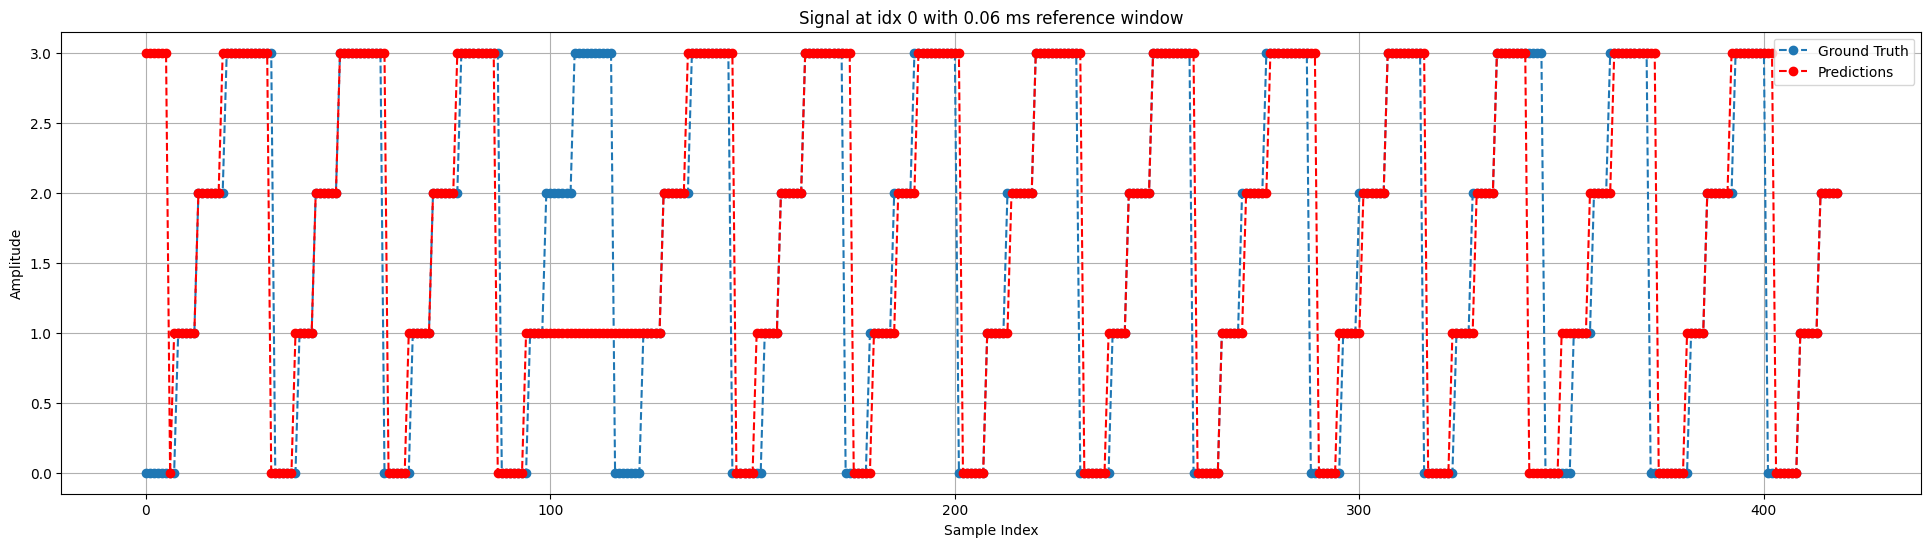

(np.float64(0.9642857142857143),
 np.float64(0.9),
 np.float64(0.8162291169451074))

In [66]:
idx = 0
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

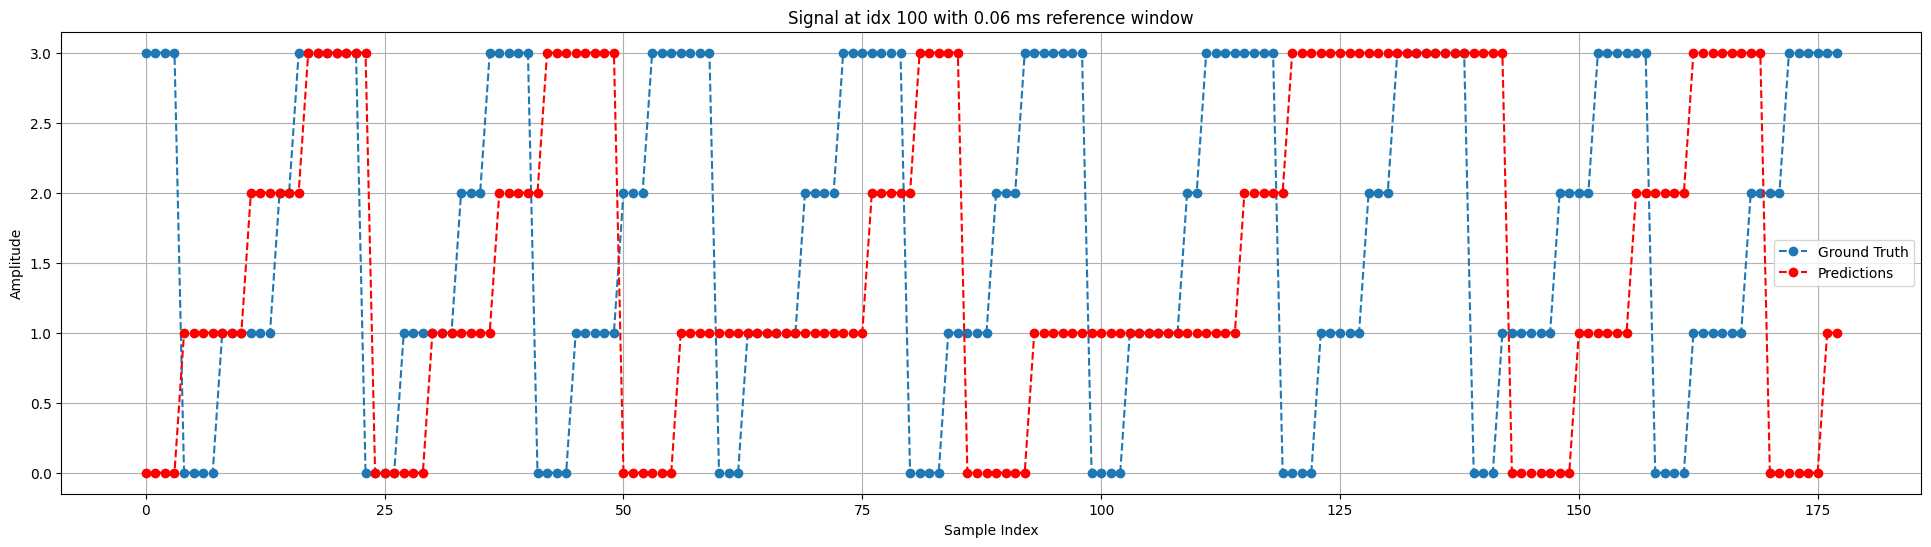

(np.float64(0.18181818181818182),
 np.float64(0.1111111111111111),
 np.float64(0.20786516853932585))

In [67]:
idx = 100
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

Although our model is far from perfect, we can still see that is indeed learning the rhythmic characteritics of the heart sound sequence.

What you would do this perliminary model?


*  Do you think the filter-extraction plays a pivotal role? What if only used the original waveform without envelograms?
*  We know how the heart sounds are described statistically (at least during screening). They have a strong Markovian character. Could we somehow use this to make our model aware of this process?
* Do you think we could have a smarter way of decoding the heart states?
*   What architectural changes could be implemented? How about recurrent networks or Transformers?

Feel free to reach out if you want to discuss these questions!
Contacts can be found at: https://miguelmartins.github.io/


